## Planning a telescope observation


Let's build your first Markov Chain! 

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative number of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

In [2]:
def weather_forecast(today):
    # set the probablity of having a sunny day tomorrow:
    if(today==0):
        p_sun = 0.5
        
    if(today==1):
        p_sun = 0.9
        
    # extract a random number to compare:
    p_random = np.random.uniform(0,1)
    
    if(p_sun>p_random):
        return 1 # sunny day
    else:
        return 0 # cloudy day

In [8]:
N = 100000

# cloudy=0 ; clear = 1

# define the chain to be filled:
chain = np.zeros(N) # in this way the first day is cloudy
prob_sun = np.zeros(N)
prob_sun[0] = 0.5 # first day cloudy

# run the algorithm N times
for i in range(1,N):
    chain[i] = weather_forecast(chain[i-1])
    prob_sun[i] = np.sum(chain)/i

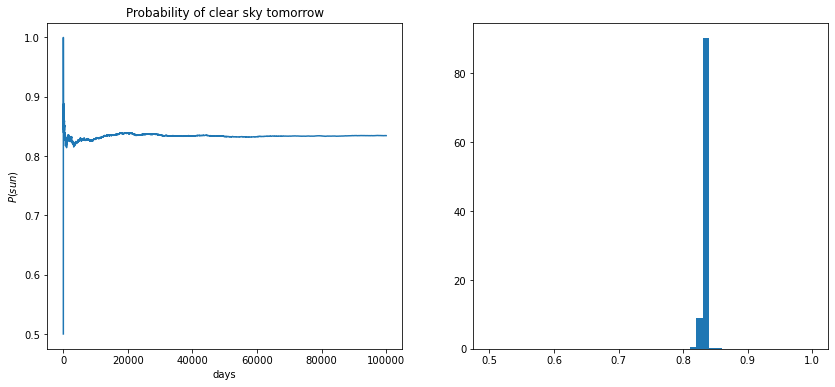

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

# trace plot
ax[0].plot(np.arange(N),prob_sun)
ax[0].set_xlabel(r'days')
ax[0].set_ylabel(r'$P(sun)$')
ax[0].set_title('Probability of clear sky tomorrow')

# histogram
ax[1].hist(prob_sun,bins=50,density=True)
plt.show()

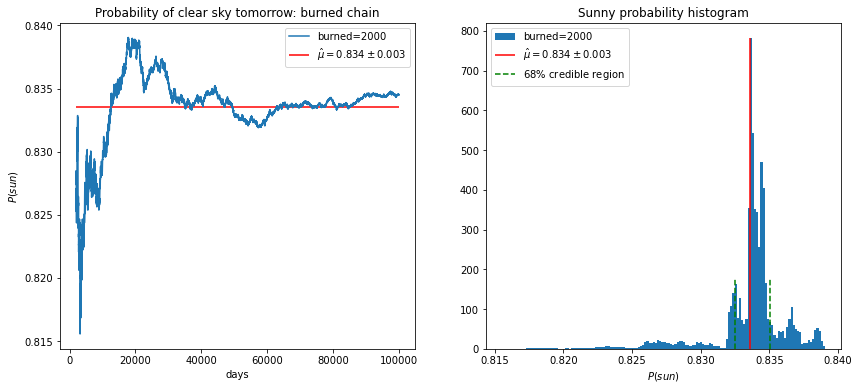

In [41]:
# burn the first steps and re-do the analysis:
burned = 2000 # let's initially try with 2000 burns

mean = np.mean(prob_sun[burned:])
std = np.std(prob_sun[burned:])
perc16 = np.percentile(prob_sun[burned:],16)
perc84 = np.percentile(prob_sun[burned:],84)
#sigma = perc84-perc16
sigmaG = astroMLstats.sigmaG(prob_sun[burned:])

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

# trace plot
ax[0].plot(np.arange(N)[burned:],prob_sun[burned:],label='burned=%i'%burned)
ax[0].set_xlabel(r'days')
ax[0].set_ylabel(r'$P(sun)$')
ax[0].set_title('Probability of clear sky tomorrow: burned chain')
#ax[0].set_ylim(0.7,0.9)
ax[0].hlines(mean,burned,N,color='red',label='$\hat{\mu}=%.3f\pm%.3f$'%(mean,std))
ax[0].legend()

# histogram

# MAP value

hist, bins = np.histogram(prob_sun[burned:], bins=150,density=True)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

ax[1].hist(prob_sun[burned:],density=True,bins=150,label='burned=%i'%burned)
plt.title('Sunny probability histogram')
plt.xlabel(r'$P(sun)$')
plt.vlines(mean,0,max(hist),color='red',label='$\hat{\mu}=%.3f\pm%.3f$'%(mean,std))
plt.vlines(perc16,0,175,color='green',label='$68\%$ credible region',ls='dashed')
plt.vlines(perc84,0,175,color='green',ls='dashed')
plt.legend()
plt.show()

Let's study how the statistics changes with the number of burned points: I will compute the standard deviation as an indicator of the deviation from the true value since it is more subject to outliers than $\sigma_G$

Text(0, 0.5, '% error')

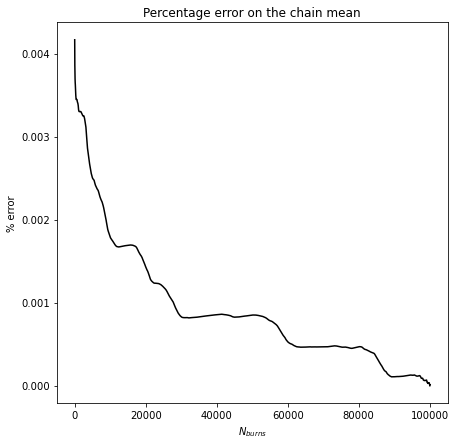

In [33]:
N_burn = np.arange(1,N) 
err_perc_burn = np.zeros(len(N_burn))

# compute the percentage error of the chain as a function of the burned elements
for n in N_burn:
    burned_chain = prob_sun[n:]
    avg_burn = np.mean(burned_chain)
    err_perc_burn[n-1] = np.std(burned_chain) / avg_burn

# plot
fig = plt.figure(figsize=(7,7))

plt.plot(N_burn,err_perc_burn,color='black')
plt.title('Percentage error on the chain mean')
plt.xlabel('$N_{burns}$')
plt.ylabel('% error')

Number of elements burned in the chain to get an uncertainty of 1/1000: 27807


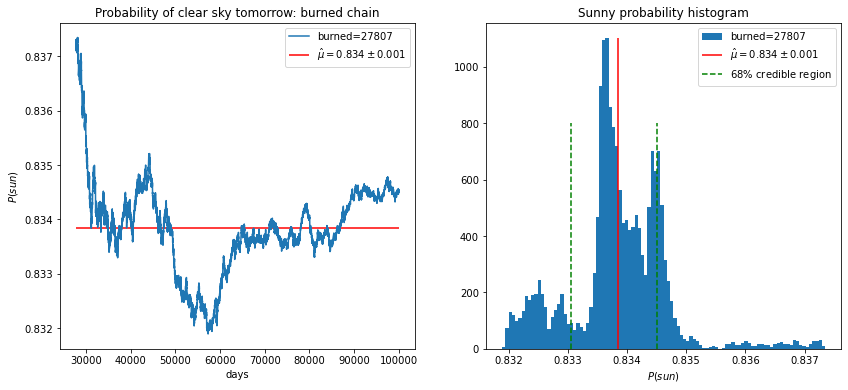

In [44]:
# let's take an uncertainty of 1/1000 as a good burn-in
N_burned = N_burn[err_perc_burn<0.001][0]
print('Number of elements burned in the chain to get an uncertainty of 1/1000:',N_burned)

# plot the chain and the histogram with the new burn-in
mean_burned = np.mean(prob_sun[N_burned:])
std_burned = np.std(prob_sun[N_burned:])
perc16_burned = np.percentile(prob_sun[N_burned:],16)
perc84_burned = np.percentile(prob_sun[N_burned:],84)
#sigma = perc84-perc16
sigmaG_burned = astroMLstats.sigmaG(prob_sun[N_burned:])

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

# trace plot
ax[0].plot(np.arange(N)[N_burned:],prob_sun[N_burned:],label='burned=%i'%N_burned)
ax[0].set_xlabel(r'days')
ax[0].set_ylabel(r'$P(sun)$')
ax[0].set_title('Probability of clear sky tomorrow: burned chain')
#ax[0].set_ylim(0.7,0.9)
ax[0].hlines(mean_burned,N_burned,N,color='red',label='$\hat{\mu}=%.3f\pm%.3f$'%(mean_burned,std_burned))
ax[0].legend()

# histogram

# MAP value

hist_burned, bins_burned = np.histogram(prob_sun[N_burned:], bins=100,density=True)
bin_mid_burned = 0.5 * (bins_burned[1:] + bins_burned[:-1])
idx_burned = np.argsort(hist_burned)[-1]
map_theta_burned = bin_mid_burned[idx_burned]

ax[1].hist(prob_sun[N_burned:],density=True,bins=100,label='burned=%i'%N_burned)
plt.title('Sunny probability histogram')
plt.xlabel(r'$P(sun)$')
plt.vlines(mean_burned,0,max(hist_burned),color='red',label='$\hat{\mu}=%.3f\pm%.3f$'%(mean_burned,std_burned))
plt.vlines(perc16_burned,0,800,color='green',label='$68\%$ credible region',ls='dashed')
plt.vlines(perc84_burned,0,800,color='green',ls='dashed')
plt.legend()
plt.show()